<a href="https://colab.research.google.com/github/Epilef86/Recomendacoes_/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

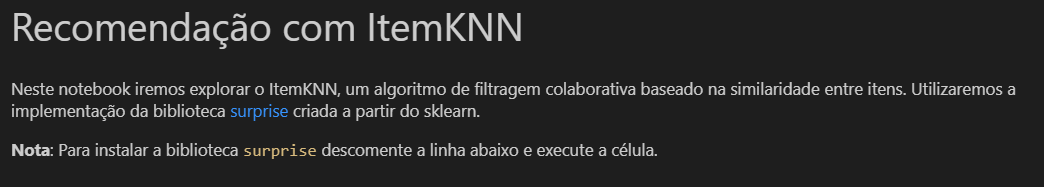

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
from google.colab import files

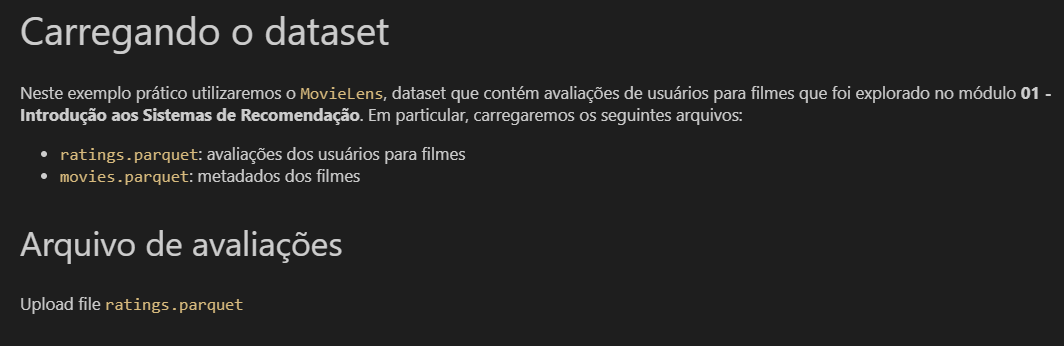

In [ ]:
%%time
_ = files.upload() # approx: 1min10s

Saving ratings.parquet to ratings (1).parquet
CPU times: user 912 ms, sys: 201 ms, total: 1.11 s
Wall time: 1min 33s


In [ ]:
df_ratings = pd.read_parquet('ratings.parquet')
df_ratings.tail()

,user_id,item_id,rating,timestamp
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


  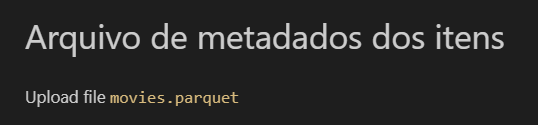

In [ ]:
%%time
_ = files.upload() # approx: 10s

Saving movies.parquet to movies (1).parquet
CPU times: user 3.94 s, sys: 514 ms, total: 4.46 s
Wall time: 7min 35s


In [ ]:
df_items = pd.read_parquet('movies.parquet')
df_items.set_index('item_id', inplace=True)
df_items.tail()

,title,genres
item_id,,
3948,Meet the Parents (2000),Comedy
3949,Requiem for a Dream (2000),Drama
3950,Tigerland (2000),Drama
3951,Two Family House (2000),Drama
3952,"Contender, The (2000)",Drama|Thriller


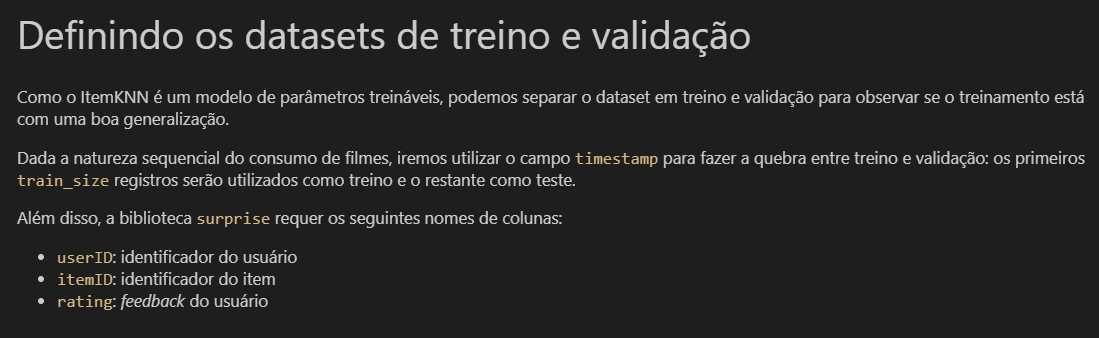

Geralmente quando trabalhamos com algoritmos de recomendação em que se tem consumo sequenciais e se quer recomendar itens que o usuário ainda não viu, usamos split temporal-ordena os dados com algum campo de timestamp, pega os x % primeiros registros do dataset como dataset de treino e o resto com validação.  

In [ ]:
df_ratings.tail()

,user_id,item_id,rating,timestamp
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


1- Tamanho de 80% do nosso dataset;

2- ordenar utilizando o campo de timestamp de forma crescente;

3- split do dataset de treino e validação, np.split pega os n primeiros registro de um dataframe e separar num primeiro grupo e o segundo num segundo grupo, precisamos passar uma lista indicando quantos registros queremos no primeiro split, segundo, terceiro...etc. Pra calcular usamos o int pra não ficar número quebrado;

4- biblioteca externa instalada precisa que os dados estejam configurados, os campo não podem estar como user_id e item_id, precisa renomer pra poder usar a biblioteca suprise;



In [ ]:
train_size = 0.8
# Ordenar por timestamp
df_ratings = df_ratings.sort_values(by='timestamp', ascending=True)

# Definindo train e valid sets
df_train_set, df_valid_set = np.split(df_ratings, [ int(train_size*df_ratings.shape[0]) ])

# Redefinindo nomes para userID e itemID
df_train_set = df_train_set.rename({'user_id': 'userID', 'item_id': 'itemID'}, axis=1)
df_valid_set = df_valid_set.rename({'user_id': 'userID', 'item_id': 'itemID'}, axis=1)

print ('Train size: ', df_train_set.shape)
print ('Valid size: ', df_valid_set.shape)

Train size:  (800167, 4)
Valid size:  (200042, 4)


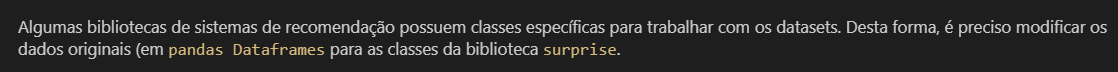

Além da exigência de ter os campos naquele formato, precisa ter a classe específica pra essa biblioteca. O surprise tem o dataset e o reader.

convert_train_valid_sets --> pega o dataframe de treino e o de validação e teremos um trains_set e valid_set já convertidos pra o formato que a biblioteca surprise exige

escala que vamos usar de 1 a 5 

train_set vai ser feito a partir de uma classe chamada dataset, que importamos acima, utilizando o load_from_df, passa o dataframe do pandas que vai servir como base pra o datase do surprise. A exigência é que as colunas estejam na ordem





In [ ]:
from surprise import Dataset, Reader
def convert_train_valid_sets(df_train_set:pd.DataFrame, df_valid_set:pd.DataFrame):
  reader = Reader(rating_scale=(1, 5))
  # The columns must correspond to user id, item id and ratings (in that order).
  train_set = (
      Dataset
      .load_from_df(df_train_set[['userID', 'itemID', 'rating']], reader)
      .build_full_trainset()
  )

  valid_set = (
      Dataset
      .load_from_df(df_valid_set[['userID', 'itemID', 'rating']], reader)
      .build_full_trainset()
      .build_testset()
  )

  return train_set, valid_set

train_set, valid_set = convert_train_valid_sets(df_train_set, df_valid_set)

In [ ]:
train_set

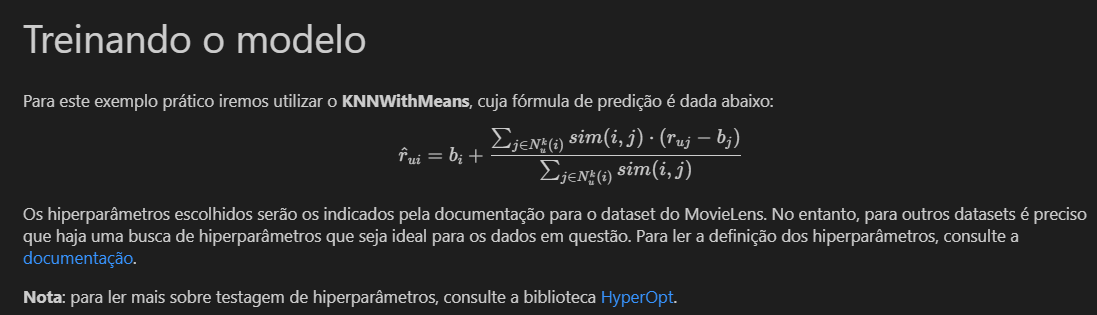

KNNWithMeans:

k=40 o número de vizinhos considerados pra fazer a predição. O 40 foi escolhido pq o dataset já foi testado na literatura;

sim_options definiu como dicionário acima. Esse dicionário contém o nome da função de similaridade que vai ser usada e user_based igual a false pq queremos fazer o item KNN e não o um user_knn;

verbose consegue ver alguns prints enquanto modelo vai ser treinado

In [ ]:
from surprise import KNNWithMeans

sim_options = {
    "name": "pearson_baseline",
    "user_based": False,  # compute similarities between items
}
model = KNNWithMeans(k=40, sim_options=sim_options, verbose=True)
model

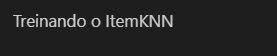

In [ ]:
%%time
model.fit(train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
CPU times: user 16.9 s, sys: 966 ms, total: 17.9 s
Wall time: 17.9 s


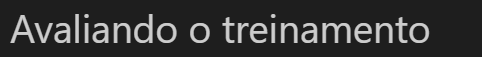

Saida do modelo foi pra esse usuário e pra esse item a estimativa do modelo é de 3.59 num range de 1 a 5. Fala quantos vizinhos foram utilizados pra computar essa nota e se essa nota foi possivel ou não.

In [ ]:
user_id = df_valid_set['userID'].sample().tolist()[0]
item_id = df_valid_set['itemID'].sample().tolist()[0]

model.predict(uid=user_id, iid=item_id)

Prediction(uid=5, iid=1456, r_ui=None, est=3.5905079814588703, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

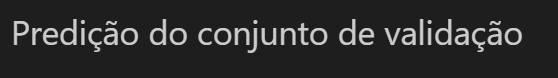

percorrendo o dataframe pandas e alicando uma função a cada linha desse dataset, a função que será passada irá pegar a estimativa da nota.

In [ ]:
%%time
df_valid_set['prediction'] = df_valid_set.apply(
    lambda x: model.predict(uid=x['userID'], iid=x['itemID']).est,
    axis=1
)

CPU times: user 27.1 s, sys: 82.2 ms, total: 27.1 s
Wall time: 29 s


In [ ]:
df_valid_set.tail()

,userID,itemID,rating,timestamp,prediction
825793,4958,2399,1,1046454338,2.561691
825438,4958,1407,5,1046454443,3.552168
825724,4958,3264,4,1046454548,3.270295
825731,4958,2634,3,1046454548,2.754026
825603,4958,1924,4,1046454590,2.584696


Dessa forma conseguimos usar o KNN pra poder treinar a partir de um conjunto de treinamento e validação feito a partir de uma split temporal e fazer essas estimativas de nota dos usuários pra os itens, mesmo se os usuários não tenham feito avaliações

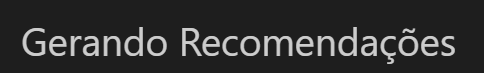

recommend_n_items --> um modelo, usuário que vai fazer a recomendação e os id dos itens que vão ser recomendados

Dentro dessa função criamos um pandas dataframe com as colunas. Pra cada item id nesse catálogo de itens recomendados chamamos a função model.predict entre esse usuário e o item id, fazemos um loop do usuário pra cada item que queremos considerar como recomendação pra ele e por fim quer pegar a estimativa do modelo pra esse par usuario - item

user_predictions --> configura pra aparecer no formato que tem id como index e o score como coluna 

user_id = 1875 defino se o usuário 

recommendable_items --> defini os itens recomendavel

recommend_n_items --> vou passar as recomendações pro modelo, usuário, catalógo de itens e numero de recomendações que será feita.

In [ ]:
def recommend_n_items(model, user_id, item_ids:np.array, n=20):
  df_predictions = pd.DataFrame(columns=['item_id', 'score'])
  for item_id in item_ids:
    prediction = model.predict(uid=user_id, iid=item_id).est
    df_predictions.loc[df_predictions.shape[0]] = [item_id, prediction]
  
  user_predictions = (
      df_predictions
      .sort_values(by='score', ascending=False)
      .head(n)
      .set_index('item_id')
  )
  return user_predictions

user_id = 1875
recommendable_items = df_items.index.values
recommend_n_items(model, user_id, recommendable_items, n=5)

,score
item_id,
1830.0,5.0
989.0,5.0
3522.0,5.0
3881.0,5.0
1471.0,5.0


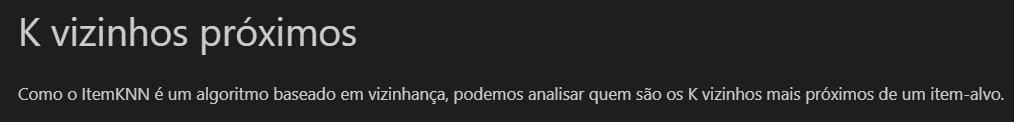


model.get_neighbors --> consegue buscar os k vizinhos de um determindo item_id, pra isso precisamos passar um idetificador interno da biblioteca e a quantidade de vizinhos que vai ser retornado.



In [ ]:
item_id = 1     # Toy Story
item_id = 1356  # Star Trek: First Contact
item_id = 260   # Star Wars: Episode IV - A New Hope
# item_id = 3578  # Gladiator

def get_item_k_neighbors(model, item_id, k=10):
  iid = model.trainset.to_inner_iid(item_id)
  neighbor_iids = model.get_neighbors(iid, k)
  item_ids = [model.trainset.to_raw_iid(iid) for iid in neighbor_iids]
  return item_ids

k = 10
title = df_items.loc[item_id]['title']
print (f'{k} vizinhos mais próximos de "{title}" (ID = {item_id})')
item_ids = get_item_k_neighbors(model, item_id, k)
df_items[df_items.index.isin(item_ids)]

10 vizinhos mais próximos de "Star Wars: Episode IV - A New Hope (1977)" (ID = 260)


,title,genres
item_id,,
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1198,Raiders of the Lost Ark (1981),Action|Adventure
1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
1291,Indiana Jones and the Last Crusade (1989),Action|Adventure
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi
2640,Superman (1978),Action|Adventure|Sci-Fi
2716,Ghostbusters (1984),Comedy|Horror
3507,"Odd Couple, The (1968)",Comedy


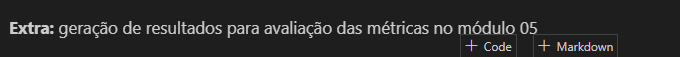

In [ ]:
from tqdm import tqdm
model_name = 'itemknn'
n = 20
df_recommendations = pd.DataFrame()
catalog = df_items.index.values
for user_id in tqdm(df_valid_set['userID'].unique()):
  user_known_items = df_train_set.query('userID == @user_id')['itemID'].unique()
  recommendable_items = np.array(list(set(catalog)-set(user_known_items)))

  user_recommendations = recommend_n_items(model, user_id, recommendable_items, n).reset_index(drop=False)
  user_recommendations['user_id'] = user_id
  df_recommendations = pd.concat([df_recommendations, user_recommendations])

df_recommendations['model'] = model_name
df_recommendations = df_recommendations.merge(
    df_valid_set,
    left_on=['user_id', 'item_id'],
    right_on=['userID', 'itemID'],
    how='left'
)
df_recommendations = df_recommendations[['model', 'user_id', 'item_id', 'rating', 'score']]
df_recommendations['rating'] = df_recommendations['rating'].fillna(0)
df_rec_bkp = df_recommendations.copy()
df_recommendations.tail()

 39%|███▉      | 700/1783 [59:56<1:32:22,  5.12s/it]

In [ ]:
df_recommendations['y_score'] = df_recommendations.apply(lambda x: {'item_id': x['item_id'], 'score': x['score']}, axis=1)
df_recommendations = df_recommendations.groupby(['model', 'user_id']).agg({'y_score': list}).reset_index(drop=False)
df_recommendations.tail()

In [ ]:
df_predictions = df_valid_set.rename({'userID': 'user_id', 'itemID': 'item_id'}, axis=1)
df_predictions['y_true'] = df_predictions.apply(lambda x: {'item_id': x['item_id'], 'rating': x['rating']}, axis=1)
df_predictions = df_predictions.groupby('user_id').agg({'y_true': list}).reset_index(drop=False)
df_predictions = df_predictions.merge(df_recommendations, on='user_id', how='inner')
df_predictions.tail()

In [ ]:
df_predictions.to_parquet(f'valid_{model_name}.parquet', index=None)